In [62]:
import ee

from IPython.display import Image

ee.Authenticate() #Usual authentication, so far. Nothing new


Successfully saved authorization token.


In [63]:
ee.Initialize()

In [64]:
#Function to download images as a list - thanks Connor Finn. 
def get_images(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage):
  coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))
  image_ids = list(map(lambda x: x['id'], coll.getInfo()['features']))

  images = list(map(lambda x: ee.Image(x), image_ids))

  return images

In [65]:
'''
Functions needed to display images and features/featurecollections are given here. 
These functions are all from other sources. Mostly from google tutorials.
'''
!pip install geojson
!pip install pygeoj
import geojson
import json
import pygeoj
import numpy as np


import folium


# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [66]:
p = [144]
r = [48]
sat = 'LANDSAT/LC08/C01/T1'
sd = '2013-05-01'
ed = '2020-05-01'
cc= 5

image_list = get_images(p, r, sat, sd, ed, cc)

In [67]:
inputimg = image_list[0]

def addBandsToLandsat8_NDWI_NDVI_PixelLonLat(image):
  '''
  Function to add bands NDWI, NDVI, and PixelLonLat to a Landsat8 image
  '''
  ndwi = image.normalizedDifference(['B3', 'B6']).rename('ndwi')
  ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi')
  imgpixLonLat = image.pixelLonLat()

  image1 = image.addBands(ndwi).addBands(ndvi).addBands(imgpixLonLat)

  return image1

inputimgWithAddedBands = addBandsToLandsat8_NDWI_NDVI_PixelLonLat(inputimg)

In [68]:
roisite = ee.Geometry.Rectangle([77999/1000, 17135/1000, 78889/1000, 17701/1000]);

In [69]:
#training = inputimg.sample({'region': nycsite, 'scale': 30.0, 'numPixels': 5000});
bandToBeUsed = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11', 'ndwi', 'ndvi']
training = inputimgWithAddedBands.select(bandToBeUsed).sample(region = roisite, scale = 30.0, numPixels = 5000); #Training is based on 500 randomly chosen pizels from within NYC area

In [70]:
numClusters = 3 #Number of clusters, I suspect. I think this should correspond to urban, non-urban, and water.
clusterer = ee.Clusterer.wekaKMeans(numClusters).train(training) #Not sure what wekaMeans is - just the code used in the GEE tutorial

In [71]:
result = inputimgWithAddedBands.cluster(clusterer); #Clustered result

In [72]:
my_map = folium.Map(location=[ 17.429, 78.483], zoom_start=9, height=500) #Adding result to folium map

my_map.add_ee_layer(result, {'min': 0, 'max': numClusters-1, 'palette': ['white', 'blue', 'green'], 'opacity':0.9}, 'clustering')
#my_map.add_ee_layer(inputimg.select(['B4','B3','B2']), {'min': 0, 'max': 30000, 'palette': [], 'opacity': 0.8}, 'image')
my_map.add_child(folium.LayerControl())

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

toBeHisted = result.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['cluster']).get('list').getInfo()[0]

(array([460.,  45., 475.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

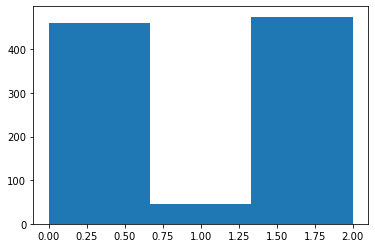

In [74]:
plt.hist(toBeHisted, bins = numClusters,  align='mid')

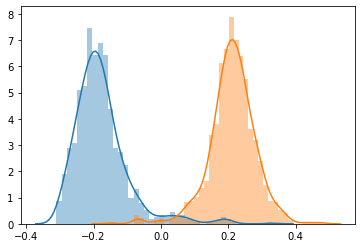

In [75]:
import seaborn as sns
sns.distplot(ee.List(inputimgWithAddedBands.select(['ndwi']).sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['ndwi']).get('list')).getInfo(),
             label='B3B6')
sns.distplot(ee.List(inputimgWithAddedBands.select(['ndvi']).sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['ndvi']).get('list')).getInfo(),label='B5B4')

In [76]:
waterRegion = inputimgWithAddedBands.select(['ndwi']).gt(0.05)
greenRegion = inputimgWithAddedBands.select(['ndvi']).gt(0.2)

In [77]:
parameters = {'min': 0,
              'max': 1.0,
              'dimensions': 600}
Image(url = waterRegion.select(['ndwi']).getThumbUrl(parameters))

#Image(url = greenRegion.select(['ndvi']).getThumbUrl(parameters))

In [78]:
my_map = folium.Map(location=[ 17.429, 78.483], zoom_start=9, height=500) #Adding result to folium map

my_map.add_ee_layer(result, {'min': 0, 'max': numClusters-1, 'palette': ['white', 'blue', 'green'], 'opacity':0.6}, 'clustering')
my_map.add_ee_layer(waterRegion.select(['ndwi']), {'min': 0, 'max': 1, 'palette': ['white', 'blue'], 'opacity':0.6}, 'ndwi')
my_map.add_ee_layer(greenRegion.select(['ndvi']), {'min': 0, 'max': 1, 'palette': ['white', 'green'], 'opacity':0.6}, 'ndvi')
my_map.add_child(folium.LayerControl())

In [79]:
import cv2 as cv2

In [80]:
import numpy as np

In [81]:
import skimage
from skimage import io

In [82]:
parameters = {'min': 0,
              'max': 2,
              'dimensions': 600,
            'palette': ['white', 'blue', 'green']}
Image(url = result.select(['cluster']).clip(roisite).getThumbUrl(parameters))

In [83]:
parameters = {'min': 0,
              'max': 1,
              'dimensions': 600,
            'palette': ['white', 'blue']}
Image(url = waterRegion.select(['ndwi']).clip(roisite).getThumbUrl(parameters))

In [84]:
parameters = {'min': -1,
              'max': 1,
              'dimensions': 600,
            'palette': ['black','white', 'green']}
Image(url = greenRegion.select(['ndvi']).clip(roisite).getThumbUrl(parameters))

In [85]:
jsonfilepath = '/home/arvindn/Research/TopicsOfInterest/Agriculture/Notes/AlmostCircleAroundHyderabad.json'
with open(jsonfilepath) as f:
    data = geojson.load(f)

coords = np.array(data['features'][0]['geometry']['coordinates'][0])[:,0:2].tolist()

eeGeom = ee.Geometry.Polygon(coords)

eeFeat = ee.Feature(eeGeom)

parameters = {'min': 0,
              'max': 1,
              'dimensions': 600,
            'palette': ['white', 'blue']}
Image(url = waterRegion.select(['ndwi']).clip(eeGeom).getThumbUrl(parameters))

In [117]:
print(image_list[0].get('REFLECTIVE_LINES').getInfo())
print(image_list[0].get('REFLECTIVE_SAMPLES').getInfo())
print(image_list[0].get('LANDSAT_SCENE_ID').getInfo())
print(image_list[0].get('DATE_ACQUIRED').getInfo())
print(image_list[0].get('WRS_PATH').getInfo())
print(image_list[0].get('WRS_ROW').getInfo())

#image_list[0].propertyNames().getInfo()

7831
7681
LC81440482013359LGN01
2013-12-25
144
48


In [86]:
jsonfilepath = '/home/arvindn/Research/TopicsOfInterest/Agriculture/Notes/AlmostCircleAroundHyderabad.json'
with open(jsonfilepath) as f:
    data = geojson.load(f)

coords = np.array(data['features'][0]['geometry']['coordinates'][0])[:,0:2].tolist()

eeGeom = ee.Geometry.Polygon(coords)

eeFeat = ee.Feature(eeGeom)

parameters = {'min': 0,
              'max': 1,
              'dimensions': 600,
            'palette': ['white', 'blue']}
hydThumbURL = waterRegion.select(['ndwi']).clip(eeGeom).getThumbURL(parameters)

In [125]:
parameters = {'min': 0,
              'max': 1,
              'scale': 30,
            'palette': ['white', 'blue'],
             'crs': inputimg.select(['B1']).projection().getInfo()['crs']}
hydDownloadURL = waterRegion.select(['ndwi']).clip(eeGeom).getDownloadURL(parameters)
#hydThumbURL = waterRegion.select(['ndwi']).clip(eeGeom).getThumbURL(parameters)

In [126]:
#z.extractall("downloadedWaterImage.tif")
date_acq = image_list[0].get('DATE_ACQUIRED').getInfo()
wrs_path = image_list[0].get('WRS_PATH').getInfo()
wrs_row = image_list[0].get('WRS_ROW').getInfo()

zipfilename = str(date_acq)+'_'+str(wrs_path)+'_'+str(wrs_row)+'_NearHyderabad.zip'
urllib.request.urlretrieve(hydDownloadURL, zipfilename)

In [130]:
zipfilename.split('.')[0]

'2013-12-25_144_48_NearHyderabad'

In [136]:
import zipfile
zipf = zipfile.ZipFile(zipfilename, 'r')
zipf.extractall()

import os
tif_filename = zipfilename.split('.')[0]+'.tif'
os.rename('download.ndwi.tif', tif_filename)

In [134]:
import cv2 as cv2
import numpy as np

from skimage import io

In [137]:
waterHyd = io.imread(tif_filename)
waterHyd.shape

In [140]:
waterHyd.min()

0

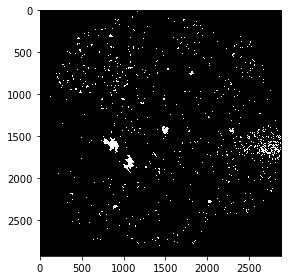

In [141]:
ret,thresh = cv2.threshold(waterHyd,0.5,255,0) #thresholding, this time using
                                            #OpenCV

io.imshow(thresh) #showing the image using skimage.io

In [142]:
#Drawing contours - not sure how openCV does it.
contours, hierarchy = cv2.findContours(thresh, 
                                       cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_SIMPLE)

Text(0.5, 1.0, '2013-12-25')

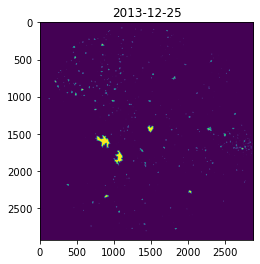

In [146]:
f, ax1 = plt.subplots(1)

frame = thresh
for i, contour in enumerate(contours):
    c_area = cv2.contourArea(contour)
    c_perimeter = cv2.arcLength(contour, True)
    if (c_area > 16):
        moments_cnt = cv2.moments(contour)
        cx = int(moments_cnt['m10']/moments_cnt['m00'])
        cy = int(moments_cnt['m01']/moments_cnt['m00'])
        #print("area: ", c_area, "centroid: ", (cx, cy), "perimeter: ", c_perimeter)
        #ax1.plot(cx, cy, 'o')
        frame = cv2.drawContours(frame, contour, -1, (0, 255, 0), 2)


frameWithContours = cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)

#ax1.imshow(frameWithContours)
ax1.imshow(frame)
ax1.set_title(str(date_acq))

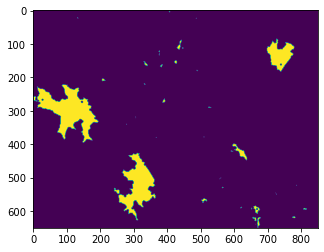

In [149]:
plt.imshow(frame[1300:1950,750:1600])

In [148]:
contoursArea = map(cv2.contourArea, contours)
contoursAreaNumpy = np.sort(list(contoursArea))
np.sort(contoursAreaNumpy)[-5:]*900/1e6 #area in km^2

array([ 1.69515,  2.40615,  4.30425, 10.14075, 13.69485])